## Double DQN算法
&emsp;&emsp;针对DQN中出现的高估问题， Hasselt等人提出了深度双Q网络算法（Double Deep Q-Network，DDQN）。该算法是将强化学习中的双Q学习应用于DQN中。在强化学习中，双Q学习的提出能在一定程度上缓解Q学习带来的过高估计问题，因此，DDQN方法为解决DQN的高估问题带来一个新的研究方向。<br>
DDQN的主要思想是在目标值计算时将动作的选择和评估分离。在更新过程中，利用两个网络来学习两组权重，分别是预测网络的权重w和目标网络的权重$w^{'}$。在DQN中，动作选择和评估都是通过目标网络来实现的。而在DDQN中，计算目标Q值时，采取目标网络获取最优动作，再通过预测网络估计该最优动作的目标Q值，这样就可以将最优动作选择和动作值函数估计分离，采用不同的样本保证独立性。DDQN的目标Q值为：
<center>$Y_{t}^{DoubleQ} = R_{t+1} + \gamma{Q}(S_{t+1},argmax_a(S_{t+1},a;\theta_t);\theta_{t}^{'})$</center>


In [1]:
import gym, random, pickle, os.path, math, glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import pdb

from atari_wrappers import make_atari, wrap_deepmind,LazyFrames
from IPython.display import clear_output
from tensorboardX import SummaryWriter

USE_CUDA = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor
Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs).cuda() if USE_CUDA else autograd.Variable(*args, **kwargs)

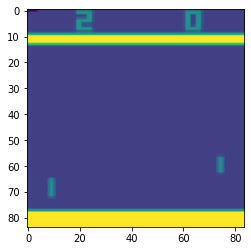

In [2]:
# Create and wrap the environment
env = make_atari('PongNoFrameskip-v4') # only use in no frameskip environment
env = wrap_deepmind(env, scale = False, frame_stack=True )
n_actions = env.action_space.n
state_dim = env.observation_space.shape

# env.render()
test = env.reset()
for i in range(100):
    test = env.step(env.action_space.sample())[0]

plt.imshow(test._force()[...,0])

#plt.imshow(env.render("rgb_array"))
# env.close()

In [3]:
class DQN(nn.Module):
    def __init__(self, in_channels=4, num_actions=5):
        """
        Initialize a deep Q-learning network as described in
        https://storage.googleapis.com/deepmind-data/assets/papers/DeepMindNature14236Paper.pdf
        Arguments:
            in_channels: number of channel of input.
                i.e The number of most recent frames stacked together as describe in the paper
            num_actions: number of action-value to output, one-to-one correspondence to action in game.
        """
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.fc4 = nn.Linear(7 * 7 * 64, 512)
        self.fc5 = nn.Linear(512, num_actions)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.fc4(x.view(x.size(0), -1)))
        return self.fc5(x)


In [4]:
class Memory_Buffer(object):
    def __init__(self, memory_size=1000):
        self.buffer = []
        self.memory_size = memory_size
        self.next_idx = 0
        
    def push(self, state, action, reward, next_state, done):
        data = (state, action, reward, next_state, done)
        if len(self.buffer) <= self.memory_size: # buffer not full
            self.buffer.append(data)
        else: # buffer is full
            self.buffer[self.next_idx] = data
        self.next_idx = (self.next_idx + 1) % self.memory_size

    def sample(self, batch_size):
        states, actions, rewards, next_states, dones = [], [], [], [], []
        for i in range(batch_size):
            idx = random.randint(0, self.size() - 1)
            data = self.buffer[idx]
            state, action, reward, next_state, done= data
            states.append(state)
            actions.append(action)
            rewards.append(reward)
            next_states.append(next_state)
            dones.append(done)
            
            
        return np.concatenate(states), actions, rewards, np.concatenate(next_states), dones
    
    def size(self):
        return len(self.buffer)


$Y_{t}^{DoubleQ} = R_{t+1} + \gamma{Q}(S_{t+1},argmax_a(S_{t+1},a;\theta_t);\theta_{t}^{'})$

In [5]:
class DDQNAgent: 
    def __init__(self, in_channels = 1, action_space = [], USE_CUDA = False, memory_size = 10000, epsilon  = 1, lr = 1e-4):
        self.epsilon = epsilon
        self.action_space = action_space
        self.memory_buffer = Memory_Buffer(memory_size)
        self.DQN = DQN(in_channels = in_channels, num_actions = action_space.n)
        self.DQN_target = DQN(in_channels = in_channels, num_actions = action_space.n)
        self.DQN_target.load_state_dict(self.DQN.state_dict())


        self.USE_CUDA = USE_CUDA
        if USE_CUDA:
            self.DQN = self.DQN.cuda()
            self.DQN_target = self.DQN_target.cuda()
        self.optimizer = optim.RMSprop(self.DQN.parameters(),lr=lr, eps=0.001, alpha=0.95)

    def observe(self, lazyframe):
        # from Lazy frame to tensor
        state =  torch.from_numpy(lazyframe._force().transpose(2,0,1)[None]/255).float()
        if self.USE_CUDA:
            state = state.cuda()
        return state

    def value(self, state):
        q_values = self.DQN(state)
        return q_values
    
    def act(self, state, epsilon = None):
        """
        sample actions with epsilon-greedy policy
        recap: with p = epsilon pick random action, else pick action with highest Q(s,a)
        """
        if epsilon is None: epsilon = self.epsilon

        q_values = self.value(state).cpu().detach().numpy()
        if random.random()<epsilon:
            aciton = random.randrange(self.action_space.n)
        else:
            aciton = q_values.argmax(1)[0]
        return aciton
    
    def compute_td_loss(self, states, actions, rewards, next_states, is_done, gamma=0.99):
        """ Compute td loss using torch operations only. Use the formula above. """
        actions = torch.tensor(actions).long()    # shape: [batch_size]
        rewards = torch.tensor(rewards, dtype =torch.float)  # shape: [batch_size]
        is_done = torch.tensor(is_done, dtype = torch.uint8)  # shape: [batch_size]
        
        if self.USE_CUDA:
            actions = actions.cuda()
            rewards = rewards.cuda()
            is_done = is_done.cuda()

        # get q-values for all actions in current states
        predicted_qvalues = self.DQN(states)

        # select q-values for chosen actions
        predicted_qvalues_for_actions = predicted_qvalues[
          range(states.shape[0]), actions
        ]

        # compute q-values for all actions in next states 
        ## Where DDQN is different from DQN
        predicted_next_qvalues_current = self.DQN(next_states)
        predicted_next_qvalues_target = self.DQN_target(next_states)
        # compute V*(next_states) using predicted next q-values
        next_state_values =  predicted_next_qvalues_target.gather(1, torch.max(predicted_next_qvalues_current, 1)[1].unsqueeze(1)).squeeze(1)
        
        # compute "target q-values" for loss - it's what's inside square parentheses in the above formula.
        target_qvalues_for_actions = rewards + gamma *next_state_values 

        # at the last state we shall use simplified formula: Q(s,a) = r(s,a) since s' doesn't exist
        target_qvalues_for_actions = torch.where(
            is_done, rewards, target_qvalues_for_actions)

        # mean squared error loss to minimize
        #loss = torch.mean((predicted_qvalues_for_actions -
        #                   target_qvalues_for_actions.detach()) ** 2)
        loss = F.smooth_l1_loss(predicted_qvalues_for_actions, target_qvalues_for_actions.detach())

        return loss
    
    def sample_from_buffer(self, batch_size):
        states, actions, rewards, next_states, dones = [], [], [], [], []
        for i in range(batch_size):
            idx = random.randint(0, self.memory_buffer.size() - 1)
            data = self.memory_buffer.buffer[idx]
            frame, action, reward, next_frame, done= data
            states.append(self.observe(frame))
            actions.append(action)
            rewards.append(reward)
            next_states.append(self.observe(next_frame))
            dones.append(done)
        return torch.cat(states), actions, rewards, torch.cat(next_states), dones

    def learn_from_experience(self, batch_size):
        if self.memory_buffer.size() > batch_size:
            states, actions, rewards, next_states, dones = self.sample_from_buffer(batch_size)
            td_loss = self.compute_td_loss(states, actions, rewards, next_states, dones)
            self.optimizer.zero_grad()
            td_loss.backward()
            for param in self.DQN.parameters():
                param.grad.data.clamp_(-1, 1)

            self.optimizer.step()
            return(td_loss.item())
        else:
            return(0)
    

In [ ]:
# if __name__ == '__main__':
    
# Training DQN in PongNoFrameskip-v4 
env = make_atari('PongNoFrameskip-v4')
env = wrap_deepmind(env, scale = False, frame_stack=True)

gamma = 0.99
epsilon_max = 1
epsilon_min = 0.01
eps_decay = 30000
frames = 1000000
USE_CUDA = True
learning_rate = 2e-4
max_buff = 100000
update_tar_interval = 1000
batch_size = 32
print_interval = 1000
log_interval = 1000
learning_start = 10000
win_reward = 18     # Pong-v4
win_break = True

action_space = env.action_space
action_dim = env.action_space.n
state_dim = env.observation_space.shape[0]
state_channel = env.observation_space.shape[2]
agent = DDQNAgent(in_channels = state_channel, action_space= action_space, USE_CUDA = USE_CUDA, lr = learning_rate)

frame = env.reset()

episode_reward = 0
all_rewards = []
losses = []
episode_num = 0
is_win = False
# tensorboard
summary_writer = SummaryWriter(log_dir = "DDQN", comment= "good_makeatari")

# e-greedy decay
epsilon_by_frame = lambda frame_idx: epsilon_min + (epsilon_max - epsilon_min) * math.exp(
            -1. * frame_idx / eps_decay)
# plt.plot([epsilon_by_frame(i) for i in range(10000)])

for i in range(frames):
    epsilon = epsilon_by_frame(i)
    state_tensor = agent.observe(frame)
    action = agent.act(state_tensor, epsilon)
    
    next_frame, reward, done, _ = env.step(action)
    
    episode_reward += reward
    agent.memory_buffer.push(frame, action, reward, next_frame, done)
    frame = next_frame
    
    loss = 0
    if agent.memory_buffer.size() >= learning_start:
        loss = agent.learn_from_experience(batch_size)
        losses.append(loss)

    if i % print_interval == 0:
        print("frames: %5d, reward: %5f, loss: %4f, epsilon: %5f, episode: %4d" % (i, np.mean(all_rewards[-10:]), loss, epsilon, episode_num))
        summary_writer.add_scalar("Temporal Difference Loss", loss, i)
        summary_writer.add_scalar("Mean Reward", np.mean(all_rewards[-10:]), i)
        summary_writer.add_scalar("Epsilon", epsilon, i)
        
    if i % update_tar_interval == 0:
        agent.DQN_target.load_state_dict(agent.DQN.state_dict())
    
    if done:
        
        frame = env.reset()
        
        all_rewards.append(episode_reward)
        episode_reward = 0
        episode_num += 1
        avg_reward = float(np.mean(all_rewards[-100:]))

summary_writer.close()
torch.save(agent.DQN.state_dict(), "trained model/DDQN_dict.pth.tar")

/home/ouyangz/.conda/envs/gym/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ouyangz/.conda/envs/gym/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


frames:     0, reward:   nan, loss: 0.000000, epsilon: 1.000000, episode:    0
frames:  1000, reward: -21.000000, loss: 0.000000, epsilon: 0.967544, episode:    1
frames:  2000, reward: -21.000000, loss: 0.000000, epsilon: 0.936152, episode:    2
frames:  3000, reward: -21.000000, loss: 0.000000, epsilon: 0.905789, episode:    3
frames:  4000, reward: -21.000000, loss: 0.000000, epsilon: 0.876422, episode:    4
frames:  5000, reward: -20.800000, loss: 0.000000, epsilon: 0.848017, episode:    5
frames:  6000, reward: -20.714286, loss: 0.000000, epsilon: 0.820543, episode:    7
frames:  7000, reward: -20.625000, loss: 0.000000, epsilon: 0.793971, episode:    8
frames:  8000, reward: -20.666667, loss: 0.000000, epsilon: 0.768269, episode:    9
frames:  9000, reward: -20.500000, loss: 0.000000, epsilon: 0.743410, episode:   10
frames: 10000, reward: -20.400000, loss: 0.000525, epsilon: 0.719366, episode:   11
frames: 11000, reward: -20.300000, loss: 0.000220, epsilon: 0.696110, episode:   

frames: 98000, reward: -20.700000, loss: 0.001503, epsilon: 0.047752, episode:  109
frames: 99000, reward: -20.700000, loss: 0.009454, epsilon: 0.046514, episode:  110
frames: 100000, reward: -20.700000, loss: 0.001626, epsilon: 0.045317, episode:  111
frames: 101000, reward: -20.700000, loss: 0.002577, epsilon: 0.044159, episode:  112
frames: 102000, reward: -20.700000, loss: 0.001259, epsilon: 0.043040, episode:  113
frames: 103000, reward: -20.900000, loss: 0.003289, epsilon: 0.041956, episode:  114
frames: 104000, reward: -20.900000, loss: 0.001674, epsilon: 0.040909, episode:  115
frames: 105000, reward: -20.800000, loss: 0.002065, epsilon: 0.039895, episode:  116
frames: 106000, reward: -20.700000, loss: 0.001460, epsilon: 0.038915, episode:  117
frames: 107000, reward: -20.700000, loss: 0.002657, epsilon: 0.037967, episode:  118
frames: 108000, reward: -20.600000, loss: 0.001927, epsilon: 0.037050, episode:  119
frames: 109000, reward: -20.500000, loss: 0.001749, epsilon: 0.0361

In [ ]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def plot_training(frame_idx, rewards, losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-100:])))
    plt.plot(moving_average(rewards,20))
    plt.subplot(132)
    plt.title('loss, average on 100 stpes')
    plt.plot(moving_average(losses, 100),linewidth=0.2)
    plt.show()

plot_training(i, all_rewards, losses)